In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from chapter05 import data_setup, engine

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [2]:
import os
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"Directory: {image_path} exists.")
else:
    print(f"Directory: {image_path} no found, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    print("Done.")
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        print("Downloading pizza, steak, sushi data...")
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)
        print("Done.")
    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)
        print("Done.")
    
    os.remove(data_path / "pizza_steak_sushi.zip")

Directory: data\pizza_steak_sushi no found, creating one...
Done.
Done.
Unzipping pizza, steak, sushi data...
Done.


In [4]:
def walk_through_data(dir_path):
    for dirpaths, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpaths}")

walk_through_data(image_path)

There are 2 directories and 0 files in data\pizza_steak_sushi
There are 3 directories and 0 files in data\pizza_steak_sushi\test
There are 0 directories and 25 files in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 files in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 files in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 files in data\pizza_steak_sushi\train
There are 0 directories and 78 files in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 files in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 files in data\pizza_steak_sushi\train\sushi


In [5]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for `torchvision.models` (manual creation)

In [7]:
manual_transform = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, manual_transform, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26d1e622c60>,
 ['pizza', 'steak', 'sushi'])

In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, auto_transforms, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x26d1e6216d0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

In [12]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\zero/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 9.20MB/s]


### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [13]:
summary(
    model=model, 
    input_size=(32, 3, 224, 224), 
    col_names=["input_size", "output_size", "num_params", "trainable"], 
    col_width=20, 
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

In [14]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [16]:
summary(
    model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [17]:
# Define loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(
    model,
    train_dataloader,
    test_dataloader,
    loss_func,
    optimizer,
    epochs=5,
    device=device
)

end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 |Train_loss: 1.0935 |Train_acc: 0.46 |Test_loss: 0.9124 |Test_acc: 0.65 |
Epochs: 2 |Train_loss: 0.8732 |Train_acc: 0.75 |Test_loss: 0.7904 |Test_acc: 0.85 |
Epochs: 3 |Train_loss: 0.7663 |Train_acc: 0.76 |Test_loss: 0.7456 |Test_acc: 0.87 |
Epochs: 4 |Train_loss: 0.7129 |Train_acc: 0.85 |Test_loss: 0.6386 |Test_acc: 0.85 |
Epochs: 5 |Train_loss: 0.6216 |Train_acc: 0.89 |Test_loss: 0.6268 |Test_acc: 0.87 |
[INFO] Total training time: 148.183 seconds


In [21]:
from typing import Tuple, List, Dict

def plot_loss_curves(results: Dict[str, List[float]]):
    
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    test_loss, test_acc = results["test_loss"], results["test_acc"]
    
    epochs = range(len(train_loss))
    
    # Plot loss
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title(f"Train & Test loss")
    plt.xlabel(f"Epochs")
    plt.legend()
    
    # Plot Acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, test_acc, label="Test Acc")
    plt.title(f"Train & Test Acc")
    plt.xlabel(f"Epochs")
    plt.legend()

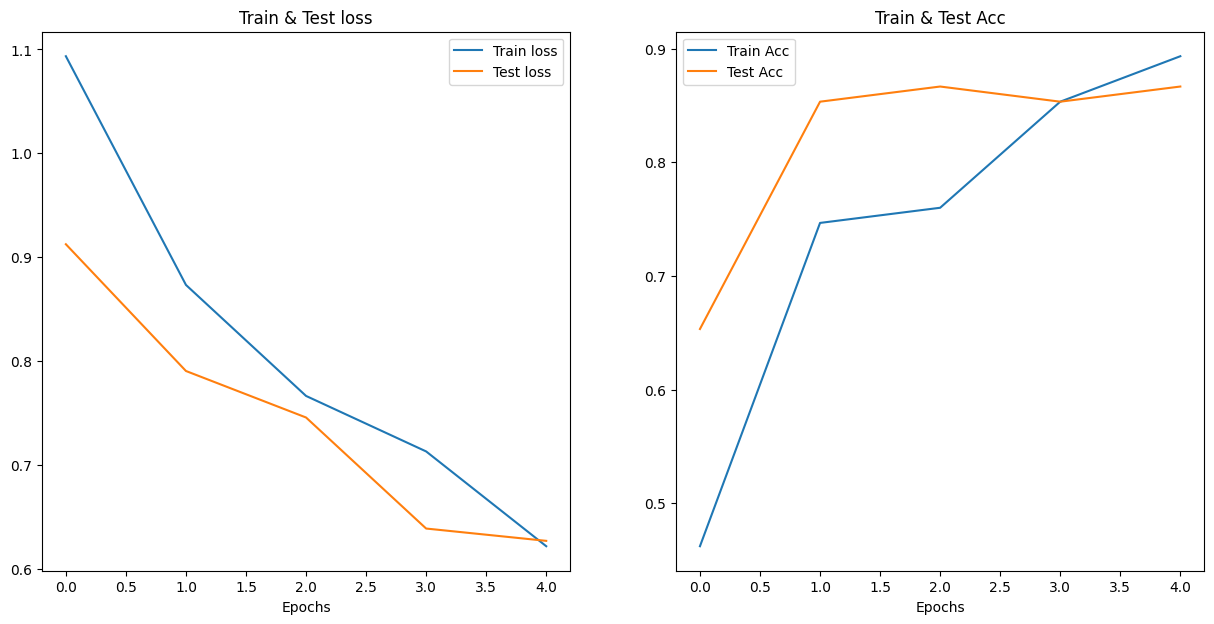

In [22]:
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [25]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(
        model: torch.nn.Module,
        image_path: str,
        class_names: List[str],
        image_size: Tuple[int, int] = (224, 224),
        transform: torchvision.transforms = None,
        device: torch.device = device
):
    # 2. Open image
    img = Image.open(image_path)
    
    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = v2.Compose([
            v2.Resize(image_size),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    ### Predict on image ###
    
    # 4. Make sure the model is on the target device
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
    
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

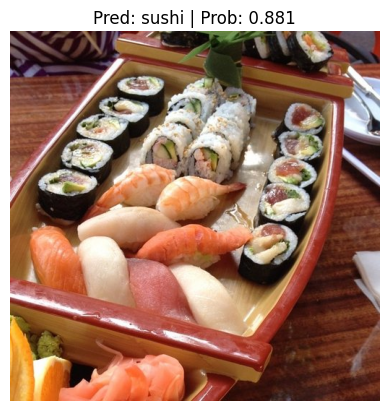

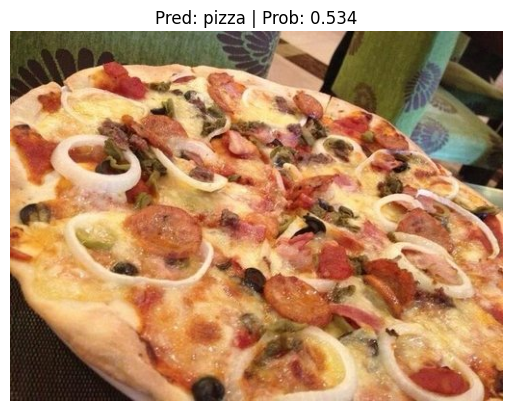

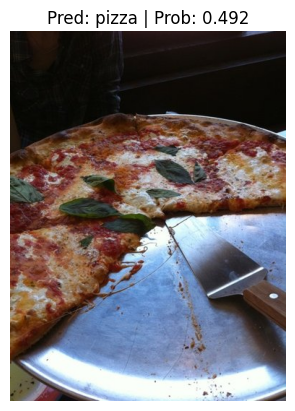

In [46]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model, image_path, class_names, image_size=(224, 224), transform=weights.transforms(), device=device)